# CRRT Mortality Prediction
## Model Construction
### Christopher V. Cosgriff, David Sasson, Colby Wilkinson, Kanhua Yin


The purpose of this notebook is to build a deep learning model that predicts ICU mortality in the CRRT population. The data is extracted in the `extract_cohort_and_features` notebook and stored in the `data` folder. This model will be mult-input and use GRUs to model sequence data. See the extraction file for a full description of the data extraction.

## Step 0: Envrionment Setup

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG
import os

from keras.optimizers import Adam, SGD, rmsprop
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Dropout, Input, Dropout, concatenate
from keras.layers.recurrent import GRU
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# for saving images
fig_fp = os.path.join('./', 'figures')
if not os.path.isdir(fig_fp):
   os.mkdir(fig_fp)

%matplotlib inline

/home/cosgriffc/env/ML/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Step 1: Load and Prepare Data

Here will we load in the data, and create train, validation, and testing splits.

In [2]:
# set tensors to float 32 as this is what GPUs expect
features_sequence = np.load('./features_sequence.npy').astype(np.float32)
features_static = np.load('./features_static.npy').astype(np.float32)
labels = np.load('./labels.npy').astype(np.float32)

x_seq_full_train, x_seq_test, x_static_full_train, x_static_test, y_full_train, y_test = train_test_split(
    features_sequence, features_static, labels, test_size = 0.20, random_state = 42)

x_seq_train, x_seq_val, x_static_train, x_static_val, y_train, y_val = train_test_split(
    x_seq_full_train, x_static_full_train, y_full_train, test_size = 0.10, random_state = 42)

Next we need to remove NANs from the data; we'll impute the trianing population mean, the simplest method suggested by David Sontag.

In [3]:
def impute_mean(source_data, input_data):
    '''
    Takes the source data, and uses it to determine means for all
    features; it then applies them to the input data.
    
    inputs:
    source_data: a tensor to provide means
    input_data: the data to fill in NA for
    
    output:
    output_data: data with nans imputed for each feature
    
    '''
    
    output_data = input_data.copy()
    
    for feature in range(source_data.shape[1]):
        feature_mean = np.nanmean(source_data[:, feature, :][np.where(source_data[:, feature, :] != 0)])
        ind_output_data = np.where(np.isnan(output_data[:, feature, :]))
        output_data[:, feature, :][ind_output_data] = feature_mean
        
    return output_data

x_seq_train_original = x_seq_train.copy()
x_seq_train = impute_mean(x_seq_train_original, x_seq_train)
x_seq_val = impute_mean(x_seq_train_original, x_seq_val)
x_seq_test = impute_mean(x_seq_train_original, x_seq_test)

## Step 2: Build Model
### Model 1

Base model, no regularization.

In [4]:
# Define inputs
sequence_input = Input(shape = (x_seq_train.shape[1], x_seq_train.shape[2], ), dtype = 'float32', name = 'sequence_input')
static_input = Input(shape = (x_static_train.shape[1], ), name = 'static_input')

# Network architecture
seq_x = GRU(units = 128)(sequence_input)

# Seperate output for the GRU later
seq_aux_output = Dense(1, activation='sigmoid', name='aux_output')(seq_x)

# Merge dual inputs
x = concatenate([seq_x, static_input])

# We stack a deep fully-connected network on the merged inputs
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)

# Sigmoid output layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

# optimizer
opt = rmsprop(lr = 0.00001)

# build model
model = Model(inputs = [sequence_input, static_input], outputs = [main_output, seq_aux_output])
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'], loss_weights = [1, 0.1])

# save a plot of the model
plot_model(model, to_file='experiment_GRU-base.svg')

# fit the model
history = model.fit([x_seq_train, x_static_train], [y_train, y_train], epochs = 500, batch_size = 128,\
                    validation_data=([x_seq_val, x_static_val], [y_val, y_val]),)

Train on 924 samples, validate on 103 samples
Epoch 1/500
924/924 [==============================] - 2s 2ms/step - loss: 0.7793 - main_output_loss: 0.7098 - aux_output_loss: 0.6952 - main_output_acc: 0.4913 - aux_output_acc: 0.5032 - val_loss: 0.7621 - val_main_output_loss: 0.6941 - val_aux_output_loss: 0.6799 - val_main_output_acc: 0.5534 - val_aux_output_acc: 0.5243
Epoch 2/500
924/924 [==============================] - 0s 247us/step - loss: 0.7749 - main_output_loss: 0.7056 - aux_output_loss: 0.6922 - main_output_acc: 0.4903 - aux_output_acc: 0.4989 - val_loss: 0.7551 - val_main_output_loss: 0.6872 - val_aux_output_loss: 0.6790 - val_main_output_acc: 0.5728 - val_aux_output_acc: 0.5243
Epoch 3/500
924/924 [==============================] - 0s 234us/step - loss: 0.7725 - main_output_loss: 0.7034 - aux_output_loss: 0.6910 - main_output_acc: 0.5097 - aux_output_acc: 0.4989 - val_loss: 0.7520 - val_main_output_loss: 0.6842 - val_aux_output_loss: 0.6784 - val_main_output_acc: 0.5922 - va

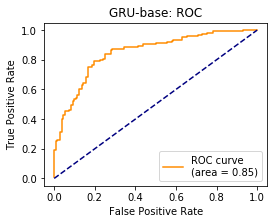

In [5]:
# plot the fit
pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_main)
auc = roc_auc_score(y_test, pred_main)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU-base')
plt.legend(loc = "lower right")
fig_name = 'gru-base.pdf'
fig.savefig(os.path.join(fig_fp, fig_name), bbox_inches='tight')
plt.show()

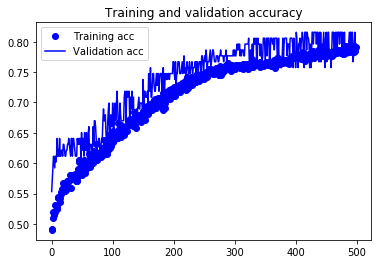

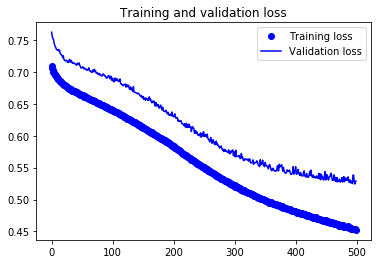

In [6]:
# plot training and validation loss and accuracy

acc = history.history['main_output_acc']
val_acc = history.history['val_main_output_acc']
loss = history.history['main_output_loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

fig_name = 'loss_svg.svg'
fig.savefig('./loss_svg.svg', bbox_inches='tight')

### 10% Dropout

In [7]:
# Define inputs
sequence_input = Input(shape = (x_seq_train.shape[1], x_seq_train.shape[2], ), dtype = 'float32', name = 'sequence_input')
static_input = Input(shape = (x_static_train.shape[1], ), name = 'static_input')

# Network architecture
seq_x = GRU(units = 128)(sequence_input)

# Seperate output for the GRU later
seq_aux_output = Dense(1, activation='sigmoid', name='aux_output')(seq_x)

# Merge dual inputs
x = concatenate([seq_x, static_input])

# We stack a deep fully-connected network on the merged inputs
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)

# Sigmoid output layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

# optimizer
opt = rmsprop(lr = 0.00001)

# build model
model = Model(inputs = [sequence_input, static_input], outputs = [main_output, seq_aux_output])
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'], loss_weights = [1, 0.1])

# save a plot of the model
#plot_model(model, to_file='experiment_GRU-DO.svg')

# fit the model
history = model.fit([x_seq_train, x_static_train], [y_train, y_train], epochs = 500, batch_size = 128,\
                    validation_data=([x_seq_val, x_static_val], [y_val, y_val]),)



Train on 924 samples, validate on 103 samples
Epoch 1/500
924/924 [==============================] - 1s 1ms/step - loss: 1.2946 - main_output_loss: 1.2198 - aux_output_loss: 0.7480 - main_output_acc: 0.5152 - aux_output_acc: 0.5087 - val_loss: 1.1543 - val_main_output_loss: 1.0797 - val_aux_output_loss: 0.7468 - val_main_output_acc: 0.5437 - val_aux_output_acc: 0.5243
Epoch 2/500
924/924 [==============================] - 0s 226us/step - loss: 1.1701 - main_output_loss: 1.0959 - aux_output_loss: 0.7427 - main_output_acc: 0.5152 - aux_output_acc: 0.5076 - val_loss: 1.0828 - val_main_output_loss: 1.0085 - val_aux_output_loss: 0.7431 - val_main_output_acc: 0.5437 - val_aux_output_acc: 0.5146
Epoch 3/500
924/924 [==============================] - 0s 218us/step - loss: 1.1137 - main_output_loss: 1.0399 - aux_output_loss: 0.7385 - main_output_acc: 0.5152 - aux_output_acc: 0.5076 - val_loss: 1.0288 - val_main_output_loss: 0.9548 - val_aux_output_loss: 0.7399 - val_main_output_acc: 0.5437 - va

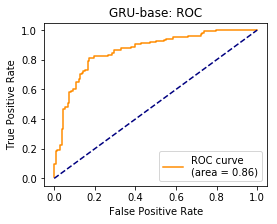

In [8]:
# plot the fit
pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_main)
auc = roc_auc_score(y_test, pred_main)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU-base')
plt.legend(loc = "lower right")
fig_name = 'gru-do.pdf'
fig.savefig(os.path.join(fig_fp, fig_name), bbox_inches='tight')
plt.show()

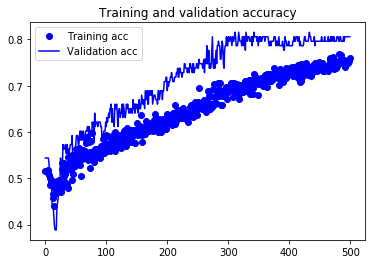

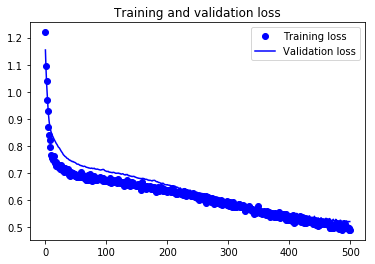

In [9]:
# plot training and validation loss and accuracy

acc = history.history['main_output_acc']
val_acc = history.history['val_main_output_acc']
loss = history.history['main_output_loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

fig_name = 'do_loss_acc.pdf'
fig.savefig(os.path.join(fig_fp, fig_name), bbox_inches='tight')